# Transfer learning y fine-tuning

En este ejemplo utilizaremos modelos preentrenado en Keras para hacer transferencia de aprendizaje desde ImageNet a un set de datos de clasificación de perros y gatos.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

### Obtención de los datos

Para mantener el set de datos pequeño y no caer en sobreentrenamiento, usaremos el 40% de este para entrenamiento (25.000 imágenes), 10% para validaciónn, y 10% para test (no consideren los errores en la descarga, no son un problema).

In [3]:
import tensorflow_datasets as tfds

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # para incluir las etiquetas
)

print(f"Ejemplos entrenamiento: {tf.data.experimental.cardinality(train_ds)}")
print(f"Ejemplos validación: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Ejemplos test: {tf.data.experimental.cardinality(test_ds)}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.KECQQ4_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Ejemplos entrenamiento: 9305
Ejemplos validación: 2326
Ejemplos test: 2326


Visualizamos algunos ejemplos, incluyendo su categoría (0 gato, 1 perro)

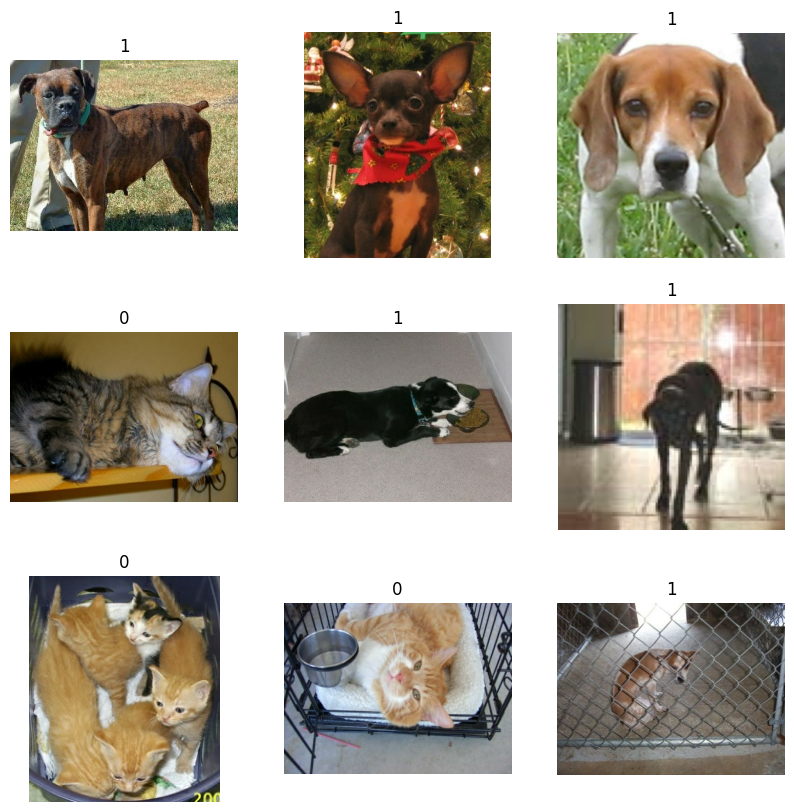

In [4]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

### Normalización de los datos

Las imágenes de este conjunto de datos tienen distintos tamaños. Para corregir esto y normalizar los datos, llevaremos cada imagen a una resolución de 150x150 pixeles, y transformaremos el valor de color (R, G y B) de cada pixel del intervalo [0,255] al [-1,1]. Para hacer esto último, utilizaremos una capa de tipo `Normalization` en la red, que aplica una transformación fija a cada dato de entrada.

In [6]:
# la capa de normalización ejecuta outputs = (inputs - mean) / sqrt(var)
mean = np.array([127.5] * 3)
var = mean ** 2
norm_layer = keras.layers.Normalization(mean=mean, variance=var)

A continuación, hacemos el _resizing_:

In [7]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

Como extra opcional, pero muy práctico, agregamos un mecanismo de `caching` para acelerar la carga de datos.

In [8]:
batch_size = 32

train_ds_batched = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds_batched = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds_batched = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### Aumento de datos

Dado que el conjunto de datos es pequeño para el tamaño de una red, utilizaremos un esquema de aumento de datos para incrementar artificialmente la cantidad de esto. En este caso en particular, aplicaremos a cada dato de manera aleatoria, al momento de ser ingresado a la red, un flip horizontal y una rotación. Al igual que antes, esta transformación la modelaremos como capas, de forma de embeberla directamente en la estructura.

In [10]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ]
)


Visualicemos algunas transformaciones:

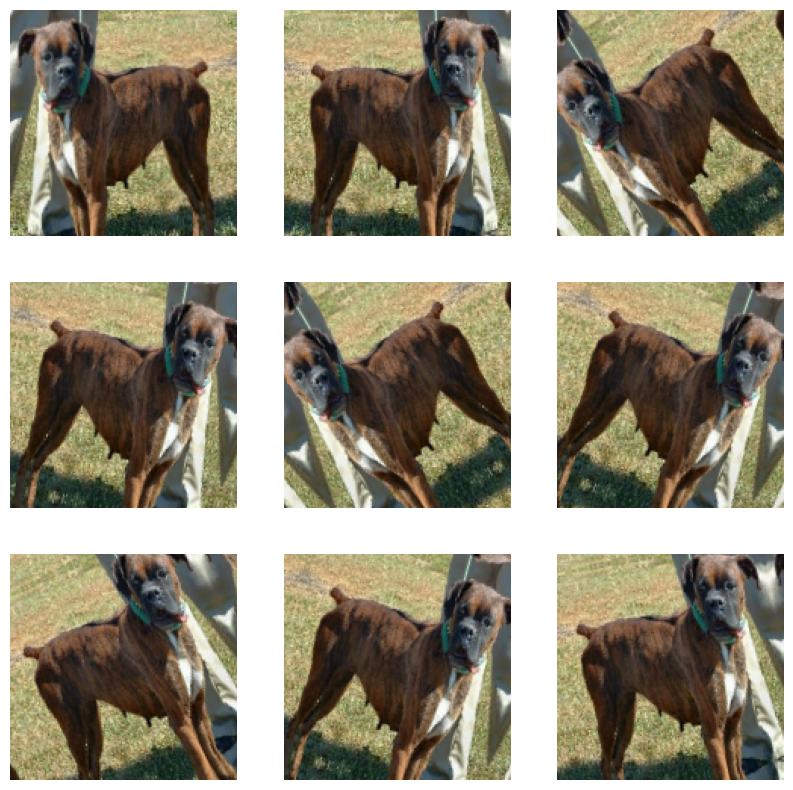

In [11]:
for images, labels in train_ds_batched.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

## Construcción del modelo

Ahora cargaremos un modelo desde Keras (Xception), que fue entrenado originalmente en ImageNet. Para hacer la transferencia, incluimos el aumento de datos, la normalización y finalmente un grupo de capas para hacer la clasificación en el nuevo set de datos (pooling, dropout, capa densa).

Para que todo esto funcione en modo de transferencia, es fundamental setear el modelo importado con `trainable=False`, de forma que sea utilizado como un extractor de características y que lo único que se entrene sean las capas del nuevo clasificador.

In [12]:
base_model = keras.applications.Xception(weights="imagenet",
                                         input_shape=(150, 150, 3),
                                         #no incluimos el clasificador
                                         include_top=False)

base_model.trainable = False
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = norm_layer(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

## Entrenamiento del modelo (solo capas de clasificación)

In [13]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds_batched, epochs=epochs, validation_data=validation_ds_batched)

Epoch 1/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - binary_accuracy: 0.8761 - loss: 0.2602 - val_binary_accuracy: 0.9708 - val_loss: 0.0842
Epoch 2/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - binary_accuracy: 0.9486 - loss: 0.1243 - val_binary_accuracy: 0.9742 - val_loss: 0.0757
Epoch 3/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - binary_accuracy: 0.9539 - loss: 0.1155 - val_binary_accuracy: 0.9738 - val_loss: 0.0743
Epoch 4/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - binary_accuracy: 0.9578 - loss: 0.1034 - val_binary_accuracy: 0.9729 - val_loss: 0.0736
Epoch 5/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - binary_accuracy: 0.9536 - loss: 0.1123 - val_binary_accuracy: 0.9721 - val_loss: 0.0733
Epoch 6/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - binary_accuracy: 0.9574 - loss: 0.1039 - val_binary_accuracy: 0.9729 - val_loss: 0.0743
Epoch 7/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - binary_accuracy: 0.9548 - loss: 0.1081 - val_binary_accuracy: 0.9716 - val_loss

## Fine-tuning

Finalmente, haremos un par de _epochs_ de fine-tuning, cuidando setear el modelo ahora en `trainable=True`. Otro aspecto relevante es el learning rate, que es mantenido en un valor bajo para evitar el sobrenetrenamiento.

In [14]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # learning rate bajo
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 5
model.fit(train_ds_batched, epochs=epochs, validation_data=validation_ds_batched)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,867,629 (79.60 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 4,100 (16.02 KB)

Epoch 1/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 134s 361ms/step - binary_accuracy: 0.8634 - loss: 0.3133 - val_binary_accuracy: 0.9557 - val_loss: 0.1085
Epoch 2/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 102s 351ms/step - binary_accuracy: 0.9271 - loss: 0.1816 - val_binary_accuracy: 0.9626 - val_loss: 0.0953
Epoch 3/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 102s 351ms/step - binary_accuracy: 0.9495 - loss: 0.1321 - val_binary_accuracy: 0.9690 - val_loss: 0.0837
Epoch 4/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 102s 351ms/step - binary_accuracy: 0.9573 - loss: 0.1054 - val_binary_accuracy: 0.9716 - val_loss: 0.0793
Epoch 5/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 102s 351ms/step - binary_accuracy: 0.9689 - loss: 0.0874 - val_binary_accuracy: 0.9712 - val_loss: 0.0769


Si bien la mejor en rendimiento no es increíble, esta sí es medible. Es importante notar como se reduce rapidamente el valor de la pérdida, lo que indica un alto riesgo de sobreentrenamiento si se continua con el proceso por más _epochs_.

## Predicción
Existen múltiples formas de hacer predicción utilizando un modelo ya entrenado. Algo que siempre es fundamental es asegurarse que los datos de entrada estén en el formato adecuado. En este caso, que las imágenes tenga la dimensión correcta.

### Predicción en base a batches
Si queremos hacer predicción sobre los ejemplos de test del set de datos con que entrenamos, basta con pedirle a `test_ds_batched` un batch (32 elementos) y luego aplicar la función `predict`.

In [15]:
batch = test_ds_batched.take(1)
prediction = model.predict(batch) > 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/tmp/ipython-input-16-3292829208.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(int(prediction[i]))


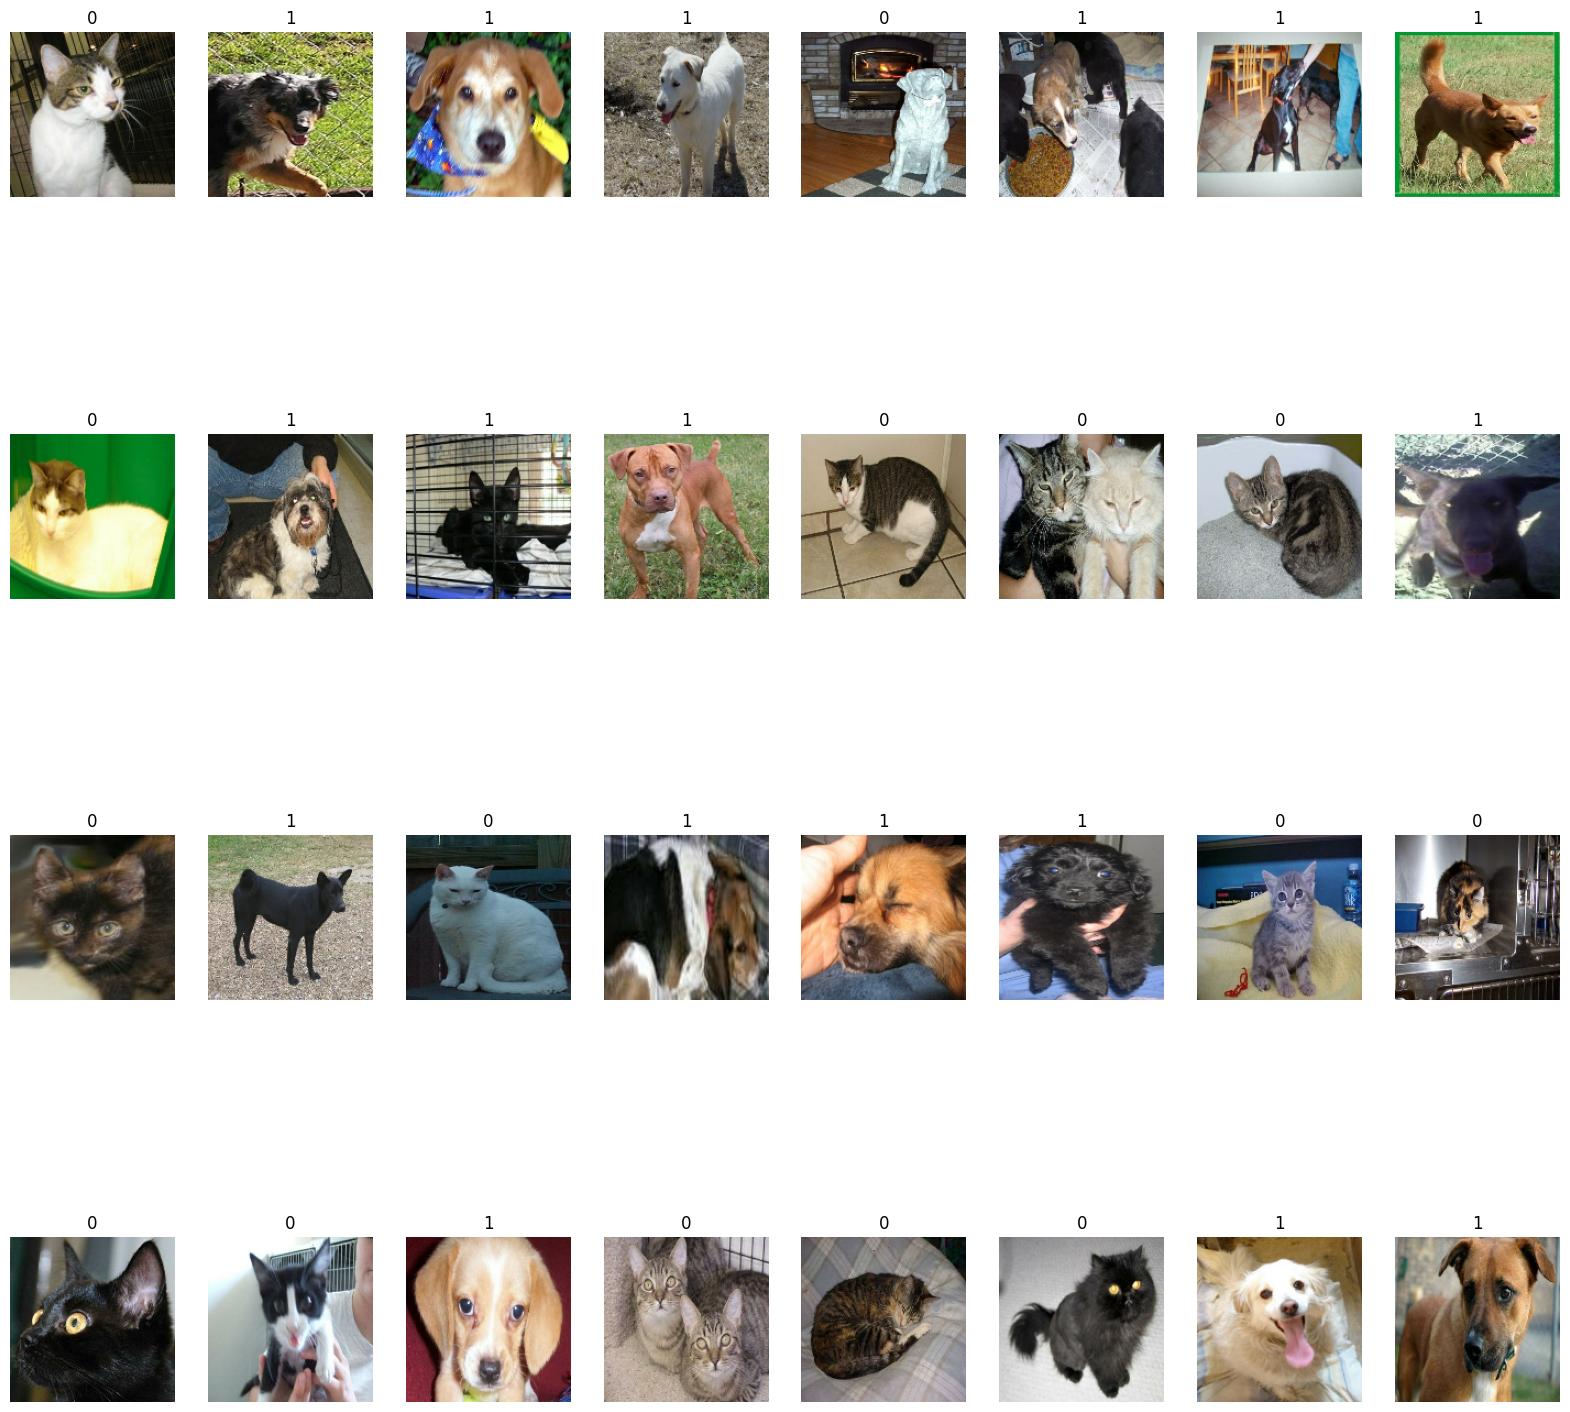

In [16]:
for images in batch:
  plt.figure(figsize=(20, 20))
  for i in range(batch_size):
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(images[0][i].numpy().astype("int32"))
      plt.title(int(prediction[i]))
      plt.axis("off")

### Predicción sobre ejemplos que no están en un batch
Muchas veces, los ejemplos no se encontrarán organizados en batches, ya sea porque no han sido procesados para que tengan ese formato, a pesar de pertenecer al mismo conjunto de datos que el usado para entrenar, o porque vienen de otra fuente. Cualquiera sea el caso, a pesar de que el modelo esté compilado para batches de un tamaño, igualmente podrá predecir sobre un conjunto de menor o mayor tamaño.

In [17]:
images = test_ds.take(9)
prediction = model.predict(images) > 0

ValueError: as_list() is not defined on an unknown TensorShape.

In [23]:
import tensorflow as tf
import numpy as np

images_list = []
labels_list = []

for batch_images, batch_labels in test_ds:
    # Si el batch es de una sola imagen, expandir dimensión:
    if len(batch_images.shape) == 3:
        images_list.append(batch_images.numpy())
        labels_list.append(batch_labels.numpy())
    else:
        images_list.extend(batch_images.numpy())
        labels_list.extend(batch_labels.numpy())

    if len(images_list) >= 9:
        break

# Tomar exactamente 9 imágenes y etiquetas
images = np.stack(images_list[:9])
labels = np.array(labels_list[:9])

# Realizar la predicción
predictions = model.predict(images) > 0






1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/tmp/ipython-input-25-3434660515.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(int(predictions[i]))  # Asegúrate de que predictions está alineado con images


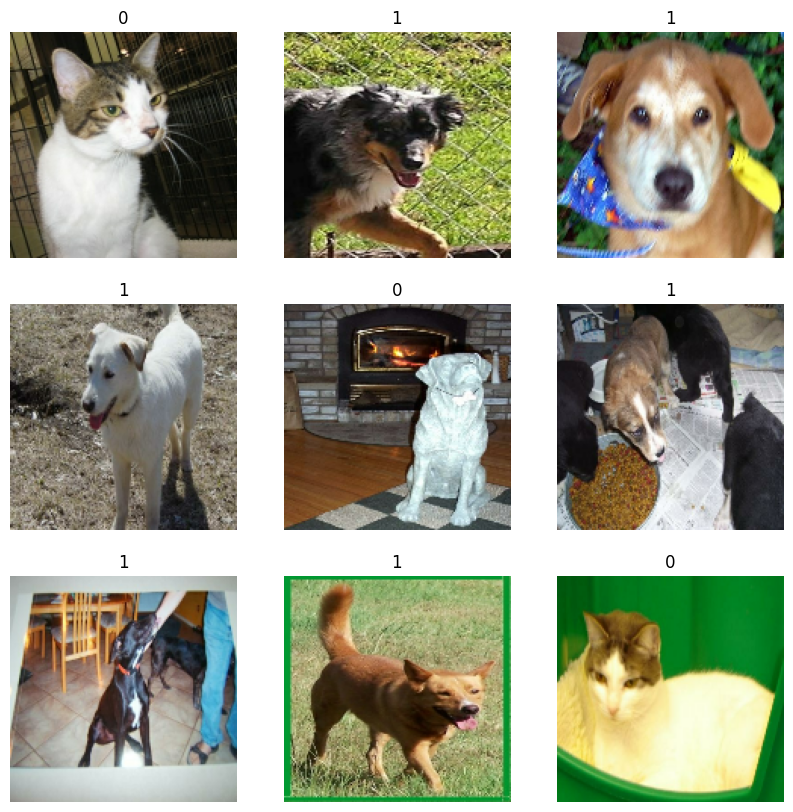

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, img in enumerate(images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img.astype("int32"))
    plt.title(int(predictions[i]))  # Asegúrate de que predictions está alineado con images
    plt.axis("off")


Esto funciona incluso para ejemplos sueltos subidos a colab.

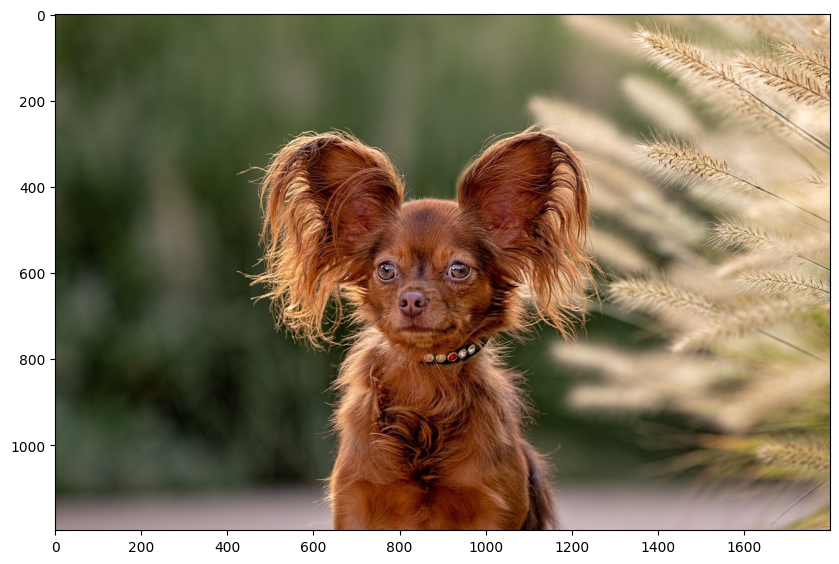

In [26]:
img = tf.keras.utils.load_img('supuestamente_un_perro.jpg')
img = tf.keras.utils.img_to_array(img)
plt.figure(figsize=(10, 10))
ax = plt.imshow(img.astype("int32"))

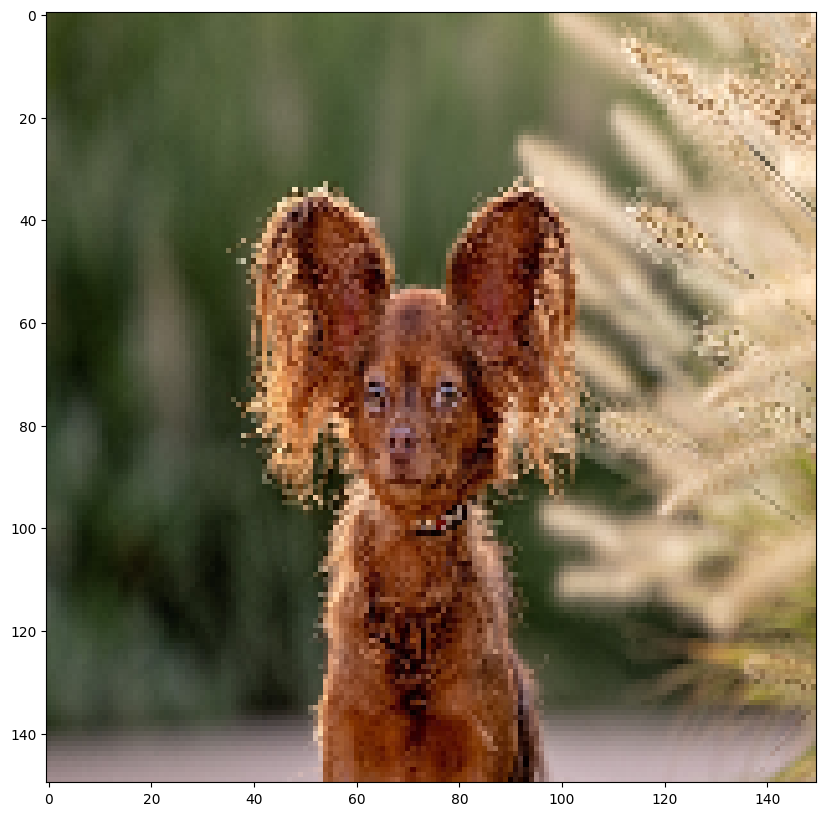

In [27]:
img = tf.image.resize(img, size)
plt.figure(figsize=(10, 10))
ax = plt.imshow(img.numpy().astype("int32"))

In [28]:
prediction = model.predict(tf.expand_dims(img, 0)) > 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/tmp/ipython-input-29-2457200001.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax = plt.title(int(prediction))


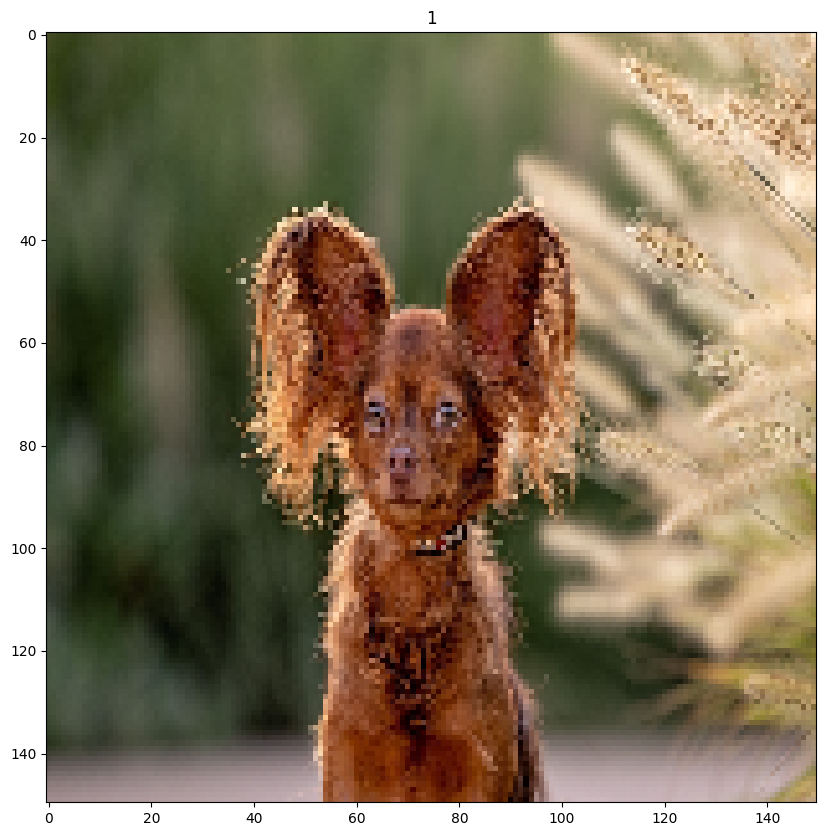

In [29]:
plt.figure(figsize=(10, 10))
plt.imshow(img.numpy().astype("int32"))
ax = plt.title(int(prediction))